In [1]:
!pip3.9 uninstall jax

Found existing installation: jax 0.3.23
Uninstalling jax-0.3.23:
  Would remove:
    /home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/jax-0.3.23.dist-info/*
    /home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/jax/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [23]:
import os
import sys
import cv2
import glob
import time
import random
from datetime import timedelta

import numpy as onp
import pandas as pd

import matplotlib.pyplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models,transforms
from torch.utils.data import TensorDataset, DataLoader,random_split

import h5py
import jax.numpy as np
from jax import random
from jax.example_libraries import optimizers
from jax.config import config
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import scipy.signal
import scipy.stats

HOME_DIR = '/home/anagara8/Documents/Autoencoder/' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

import integrator_rnn_tutorial.integrator as integrator
import integrator_rnn_tutorial.rnn as rnn
import integrator_rnn_tutorial.utils as utils

from importlib import reload

from skimage.feature import hog
from skimage import data, exposure

from scipy.stats import norm
from scipy.signal import savgol_filter

In [24]:
torch.manual_seed(42)
onp_rng = onp.random.RandomState(seed=42) # For CPU-based numpy randomness


SHAKE_PARAMETER = 50
SHAKE_PARAMETER_INDIVIDUAL = 10

ONLY_SPINE_FRAME = 224
DISTANCE_NORMALIZER = 150.0
ANGLE_NORMALIZER = 180.0

In [25]:
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# Integrator RNN hyperparameters
u = 1         # Number of inputs to the RNN
n = 100       # Number of units in the RNN
o = 1         # Number of outputs in the RNN

# The scaling of the recurrent parameters in an RNN really matters. 
# The correct scaling is 1/sqrt(number of recurrent inputs), which 
# yields an order 1 signal output to a neuron if the input is order 1.
# Given that VRNN uses a tanh nonlinearity, with min and max output 
# values of -1 and 1, this works out.  The scaling just below 1 
# (0.95) is because we know we are making a line attractor so, we 
# might as well start it off basically right 1.0 is also basically 
# right, but perhaps will lead to crazier dynamics.
param_scale = 0.85 # Scaling of the recurrent weight matrix

# Optimization hyperparameters
num_batchs = 10000         # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.025          # initial learning rate
decay_factor = 0.99975     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100 

# Loading Custom Pose Data

In [26]:
datapoints = pd.read_hdf("/media/data_cifs/anagara8/FC-A_17202338-Akash-2022-10-02/videos/video_2018Y_08M_07D_09h_51m_01s_cam_17202338-0000DLC_resnet50_SingleVideoSpineAnnotation_video_2018Y_08M_07D_09h_51m_01s_cam_17202338-0000Oct2shuffle2_500000.h5")
dataframe_reference = "DLC_resnet50_SingleVideoSpineAnnotation_video_2018Y_08M_07D_09h_51m_01s_cam_17202338-0000Oct2shuffle2_500000"

number_of_datapoints = int(len(datapoints)/1000)
print("#Datapoints:", number_of_datapoints)

#Datapoints: 108


In [27]:
nose_x = [None]*number_of_datapoints
nose_y = [None]*number_of_datapoints

innerear_x = [None]*number_of_datapoints
innerear_y = [None]*number_of_datapoints

spine1_x = [None]*number_of_datapoints
spine1_y = [None]*number_of_datapoints

spine2_x = [None]*number_of_datapoints
spine2_y = [None]*number_of_datapoints

spine3_x = [None]*number_of_datapoints
spine3_y = [None]*number_of_datapoints

spine4_x = [None]*number_of_datapoints
spine4_y = [None]*number_of_datapoints

tailstart_x = [None]*number_of_datapoints
tailstart_y = [None]*number_of_datapoints
#######################################################
previous_nose_x = 0
previous_nose_y = 0

previous_innerear_x = 0
previous_innerear_y = 0

previous_spine1_x = 0
previous_spine1_y = 0

previous_spine2_x = 0
previous_spine2_y = 0

previous_spine3_x = 0
previous_spine3_y = 0

previous_spine4_x = 0
previous_spine4_y = 0

previous_tailstart_x = 0
previous_tailstart_y = 0

In [28]:
# Smoothing based on previous frames:
print("Iterating Dataframe...")
unsure_point_count = 0
for idx in range(0, number_of_datapoints):
    nose_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['x'])
    nose_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Nose']['y'])
    if  not abs(nose_x[idx] - previous_nose_x) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_x[idx] = previous_nose_x
    if  not abs(nose_y[idx] - previous_nose_y) > SHAKE_PARAMETER_INDIVIDUAL:
        nose_y[idx] = previous_nose_y
    
    
    innerear_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['x'])
    innerear_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['InnerEar']['y'])
    if  not abs(innerear_x[idx] - previous_innerear_x) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_x[idx] = previous_innerear_x
    if  not abs(innerear_y[idx] - previous_innerear_y) > SHAKE_PARAMETER_INDIVIDUAL:
        innerear_y[idx] = previous_innerear_y

    spine1_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['x'])
    spine1_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine1']['y'])  
    if  not abs(spine1_x[idx] - previous_spine1_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_x[idx] = previous_spine1_x
    if  not abs(spine1_y[idx] - previous_spine1_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine1_y[idx] = previous_spine1_y

    spine2_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['x'])
    spine2_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine2']['y'])    
    if  not abs(spine2_x[idx] - previous_spine2_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_x[idx] = previous_spine2_x
    if  not abs(spine2_y[idx] - previous_spine2_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine2_y[idx] = previous_spine2_y


    spine3_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['x'])
    spine3_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine3']['y'])
    if  not abs(spine3_x[idx] - previous_spine3_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_x[idx] = previous_spine3_x
    if  not abs(spine3_y[idx] - previous_spine3_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine3_y[idx] = previous_spine3_y

    spine4_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['x'])
    spine4_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['Spine4']['y'])
    if  not abs(spine4_x[idx] - previous_spine4_x) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_x[idx] = previous_spine4_x
    if  not abs(spine4_y[idx] - previous_spine4_y) > SHAKE_PARAMETER_INDIVIDUAL:
        spine4_y[idx] = previous_spine4_y


    tailstart_x[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['x'])
    tailstart_y[idx] = float(datapoints.iloc[idx][dataframe_reference]['TailStart']['y'])
    if  not abs(tailstart_x[idx] - previous_tailstart_x) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_x[idx] = previous_tailstart_x
    if  not abs(tailstart_y[idx] - previous_tailstart_y) > SHAKE_PARAMETER_INDIVIDUAL:
        tailstart_y[idx] = previous_tailstart_y

print("Done!")

Iterating Dataframe...
Done!


In [31]:
print("Smoothing Individual Points...")
# Smoothing Individual Parts
smooth_nose_x = [int(x) for x in savgol_filter(nose_x, 15, 3, mode='nearest')]
smooth_nose_y = [int(y) for y in savgol_filter(nose_y, 15, 3, mode='nearest')]

smooth_innerear_x = [int(x) for x in savgol_filter(innerear_x, 15, 3, mode='nearest')]
smooth_innerear_y = [int(y) for y in savgol_filter(innerear_y, 15, 3, mode='nearest')]

smooth_spine1_x = [int(x) for x in savgol_filter(spine1_x, 15, 3, mode='nearest')]
smooth_spine1_y = [int(y) for y in savgol_filter(spine1_y, 15, 3, mode='nearest')]

smooth_spine2_x = [int(x) for x in savgol_filter(spine2_x, 15, 3, mode='nearest')]
smooth_spine2_y = [int(y) for y in savgol_filter(spine2_y, 15, 3, mode='nearest')]


smooth_spine3_x = [int(x) for x in savgol_filter(spine3_x, 15, 3, mode='nearest')]
smooth_spine3_y = [int(y) for y in savgol_filter(spine3_y, 15, 3, mode='nearest')]

smooth_spine4_x = [int(x) for x in savgol_filter(spine4_x, 15, 3, mode='nearest')]
smooth_spine4_y = [int(y) for y in savgol_filter(spine4_y, 15, 3, mode='nearest')]

smooth_tailstart_x = [int(x) for x in savgol_filter(tailstart_x, 15, 3, mode='nearest')]
smooth_tailstart_y = [int(y) for y in savgol_filter(tailstart_y, 15, 3, mode='nearest')]
print("Done Smoothing Points!")

Smoothing Individual Points...
Done Smoothing Points!


In [49]:
data_list = []
no_append_count = 0
previous_part_x = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}
previous_part_y = {"Nose":0.0, "InnerEar":0.0, "Spine1":0.0, "Spine2":0.0, "Spine3":0.0, "Spine4":0.0, "TailStart":0.0}

print("Iterating Dataframe...")
for idx in range(0, int(number_of_datapoints)):
    part_list = []
#     for part in EXPECTED_PART_LIST:
#         part_x = float(datapoints.iloc[idx][dataframe_reference][part]['x'])
#         part_y = float(datapoints.iloc[idx][dataframe_reference][part]['y'])
#         if  not abs(part_x - previous_part_x[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_x = previous_part_x[part]
#         else:
#             previous_part_x[part] = part_x
            
#         if  not abs(part_y - previous_part_y[part]) > SHAKE_PARAMETER_INDIVIDUAL:
#             part_y = previous_part_y[part]
#         else:
#             previous_part_y[part] = part_y

#     part_list.append([smooth_nose_x[idx], smooth_nose_y[idx], "Nose"])
#     part_list.append([smooth_innerear_x[idx], smooth_innerear_y[idx], "InnerEar"])
#     part_list.append([smooth_spine1_x[idx], smooth_spine1_y[idx], "Spine1"])
#     part_list.append([smooth_spine2_x[idx], smooth_spine2_y[idx], "Spine2"])
#     part_list.append([smooth_spine3_x[idx], smooth_spine3_y[idx], "Spine3"])
#     part_list.append([smooth_spine4_x[idx], smooth_spine4_y[idx], "Spine4"])
#     part_list.append([smooth_tailstart_x[idx], smooth_tailstart_y[idx], "TailStart"])
    
    try:
        data_list.append([smooth_nose_x[idx], smooth_nose_y[idx], 
                          smooth_innerear_x[idx], smooth_innerear_y[idx],
                          smooth_spine1_x[idx], smooth_spine1_y[idx],
                          smooth_spine2_x[idx], smooth_spine2_y[idx],
                          smooth_spine3_x[idx], smooth_spine3_y[idx],
                          smooth_spine4_x[idx], smooth_spine4_y[idx],
                          smooth_tailstart_x[idx], smooth_tailstart_y[idx]])
    except:
        no_append_count += 1
#         print("Didn't append for index", idx)

print("Didn't append for a total of "+str(no_append_count)+" rows.")
print("Done!\n")

Iterating Dataframe...
Didn't append for a total of 0 rows.
Done!



# Trying New LFADS

In [50]:
data_list[0]

[183, 363, 207, 343, 226, 339, 244, 338, 268, 349, 277, 363, 286, 382]

In [51]:
from lfads import LFADS_Net

ModuleNotFoundError: No module named 'utils'

In [38]:
model = LFADS_Net(inputs_dim = num_cells, T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

NameError: name 'LFADS_Net' is not defined

# Back to LFADS

In [35]:
targets.shape

(128, 25, 1)

Seed: 35909


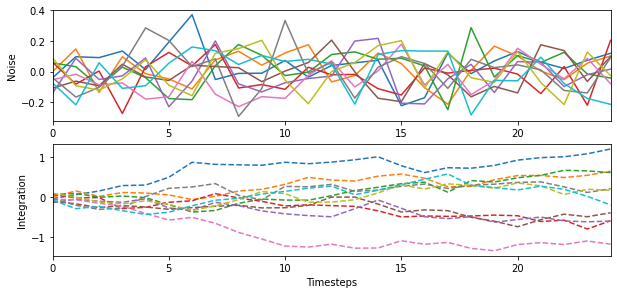

In [6]:
# JAX handles randomness differently than numpy or matlab. 
# one threads the randomness through to each function. 
#  It's a bit tedious, but very easy to understand and with
# reliable effect.
seed = onp.random.randint(0, 1000000) # get randomness from CPU level numpy
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 10    # how many examples to plot
# With this split command, we are always getting a new key from the old key,
# and I use first key as as source of randomness for new keys.
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
# In this way, the same top level randomness source stays random.

# The number of examples to plot is given by the number of 
# random keys in this function.
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)

# Plot the input to the RNN and the target for the RNN.
integrator.plot_batch(ntimesteps, inputs, targets)

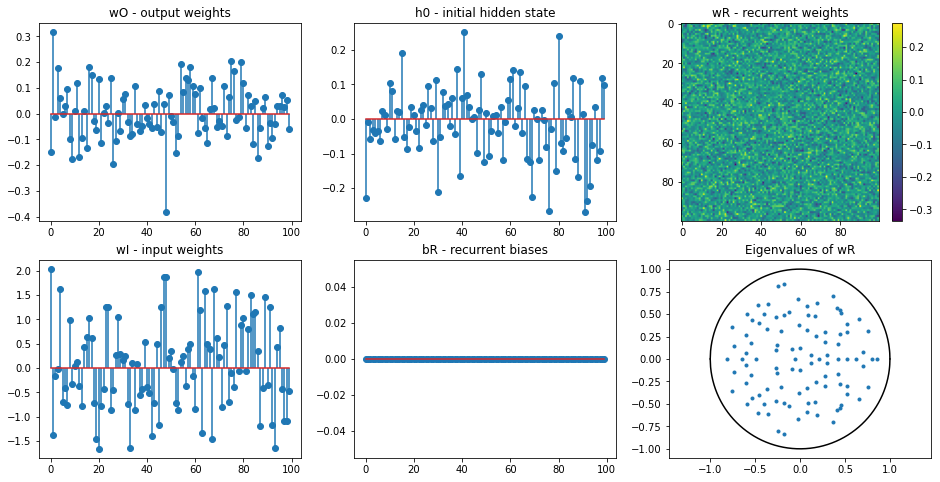

In [7]:
# Init some parameters for training.
key, subkey = random.split(key, 2)
init_params = rnn.random_vrnn_params(subkey, u, n, o, g=param_scale)
rnn.plot_params(init_params)

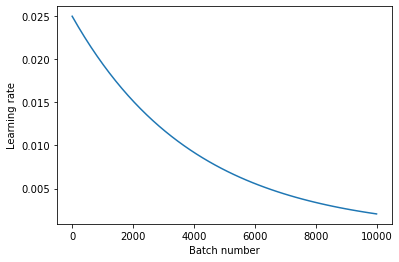

In [8]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

In [9]:
reload(rnn)
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, batch_size)
    inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)
    opt_state = rnn.update_w_gc_jit(batch, opt_state, opt_update, get_params, inputs,
                                  targets, max_grad_norm, l2reg)
    if batch % print_every == 0:
        params = get_params(opt_state)
        all_train_losses.append(rnn.loss_jit(params, inputs, targets, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 1.50 sec, step size: 0.02500, training loss 0.2631
Batch 100 in 0.85 sec, step size: 0.02438, training loss 0.0346
Batch 200 in 0.79 sec, step size: 0.02378, training loss 0.0347
Batch 300 in 0.88 sec, step size: 0.02319, training loss 0.0396
Batch 400 in 0.81 sec, step size: 0.02262, training loss 0.0324
Batch 500 in 0.86 sec, step size: 0.02206, training loss 0.0368
Batch 600 in 0.85 sec, step size: 0.02152, training loss 0.0301
Batch 700 in 0.76 sec, step size: 0.02099, training loss 0.0296
Batch 800 in 0.76 sec, step size: 0.02047, training loss 0.0293
Batch 900 in 0.94 sec, step size: 0.01996, training loss 0.0284
Batch 1000 in 0.84 sec, step size: 0.01947, training loss 0.0274
Batch 1100 in 0.85 sec, step size: 0.01899, training loss 0.0280
Batch 1200 in 0.79 sec, step size: 0.01852, training loss 0.0269
Batch 1300 in 0.89 sec, step size: 0.01806, training loss 0.0276
Batch 1400 in 0.80 sec, step size: 0.01762, training loss 0.0261
Batch 1500 in 0.86 sec, step size: 0.

KeyboardInterrupt: 

In [ ]:
import scipy.io
mat = scipy.io.loadmat('/home/anagara8/Downloads/Assignment 6/catsndogs.mat')

In [ ]:
cats = mat['cats']

In [ ]:
dogs = mat['dogs']

In [ ]:
cats

In [ ]:
new_data = {"cats":cats, "dogs":dogs}

In [ ]:
np.save("catsanddogs.npy", new_data)